## Experiment 1 - Naives RAG System

Jetzt, wo wir einen **Vectorstore** (unsere knowledge base) und synthetischen QA Paare haben, können wir unser naives RAG System über die Fragen laufen, Antworten generieren und diese bewerten lassen. <br>
<br>
• Schritt 1: **Naive RAG pipeline aufsetzen**: Zunächst erstellen wir eine RAG pipeline.<br>
<br>
• Schritt 2: **Antworten generieren**: Fragen werden durch das System geschickt.<br>
<br>
• Schritt 3: **Performance messen**: Die generierten Antworten mit den 3 Metriken der *RAG Triade* bewertet.<br>
<br>

In [28]:
# Imports & keys 

import os
os.chdir("/workspace")

from pathlib import Path
import json
import sys, subprocess, json, asyncio, nest_asyncio
nest_asyncio.apply()

import src.graph.naive_rag as naive_rag_graph
from src.graph.components.configuration import Configuration

from langchain_core.runnables import RunnableConfig

### Was macht die Pipeline?

Die erste pipeline ist bewusst so einfach wie möglich aufgebaut: <br>
<br>
Frage → relevante Dokumente werden gesucht → LLM wird mit der Frage + relevanten Dokumente angereichert → LLM generiert Antwort. 
<br>
Die genauen Funktionen (retrival + answer generation) sind `src/graph/naive_rag.py`.<br>

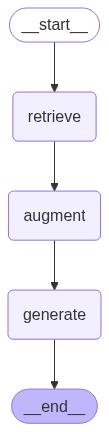

In [29]:
naive_rag_graph.graph

In [30]:
# graph configuration 
cfg = Configuration(
    provider="anthropic", # choose the provider 
    answer_gen_model="claude-3-5-haiku-20241022", # choose the LLM gen model
    top_k=10, # number of top document chunks to retrieve
    num_answers=3, # number of answers to generate 
)

run_cfg = RunnableConfig(
    configurable=cfg.model_dump()
    )

In [31]:
# run a test question
query = "welche neuen medikamente zur behandlung von psychosen gibt es und wie wirken diese?"

result = naive_rag_graph.graph.invoke(
    {"question": query}, 
    config = run_cfg)

#result

In [32]:
# question
print(f"Frage: \n{result['question']}")
print("-----"*10)
# context
for i, doc in enumerate(result["context"][:3], start=1):
    print(f"\nContext No. {i}:")
    print(f"Title: {doc.metadata.get('title')}")
    print(f"Doc ID: {doc.id}")
    print(f"Text:\n{doc.page_content[:400]}...")  
print("-----"*10)
# answer
for i, doc in enumerate(result["answers"], start=1):
    print(f"\nAnswer No. {i}")
    print(f"Answer: {doc}")


Frage: 
welche neuen medikamente zur behandlung von psychosen gibt es und wie wirken diese?
--------------------------------------------------

Context No. 1:
Title: FDA lässt neuartiges Medikament zur Behandlung von Schizophrenie zu
Doc ID: a452a6ef-ebd0-4b60-a60d-4503b0d6d10e
Text:
„Zudem ist es prinzipiell gut, wenn Behandelnde aus einem breiten Spektrum an guten Medikamenten zur Behandlung der Patienten wählen können. Je nach Person und Krankheitsbild können unterschiedliche Medikamente besser passen. Dies ist seit einigen Jahrzehnten der erste neue Ansatz für ein Schizophrenie-Medikament mit einer offenbar guten Wirksamkeit und anderen Nebenwirkungen. Ob KarXT die bisheri...

Context No. 2:
Title: FDA lässt neuartiges Medikament zur Behandlung von Schizophrenie zu
Doc ID: 3cab0201-0ca6-43ee-931b-94de1be567d1
Text:
„Obwohl die Schizophrenie eine der sozioökonomisch teuersten Erkrankung mit einer Lebenszeitreduktion von mehr als 15 Jahren und einer massiven Einschränkung der Lebensq

### Antworten für das gesamte Datenset erzeugen

Für jede Frage generieren wir **drei** Antworten. Dadurch minimieren wir Zufallseffekte und machen die spätere Messung robuster.


In [7]:
import pandas as pd
import time
from tqdm import tqdm

# load generated dataset
synth_data = pd.read_csv("data/synthetic_qa_pairs/synthetic_qa_pairs_filtered.csv")

results = []

# iterate through the questions and generate answers
for idx in tqdm(range(len(synth_data)), desc=f"Generating Answer for Question..."):
    question = synth_data.iloc[idx]['input']
    
    try:
        # Run RAG pipeline
        start_time = time.time()
        result = naive_rag_graph.graph.invoke(
            {"question": question}, 
            config=run_cfg
        )
        process_time = time.time() - start_time
        
        # Create base result dictionary
        result_dict = {
            'query_id': idx, # the query ID
            'question': question, # the query
            'gold_answer': synth_data.iloc[idx]['expected_output'], # the gold answer (we don't need it, but you can use it for your own eval)
            'latency': process_time, # processing time (how long does it take to get the answer?)
            'context': [ctx.page_content for ctx in result['context']], # the retrieved context chunks
        }
        
        # Add individual answers (if we generate more than 1)
        for ans_idx, answer in enumerate(result['answers'], 1):
            result_dict[f'answer_no_{ans_idx}'] = answer # each generated answer (in this case: 3)
        
        results.append(result_dict)
        
    except Exception as e:
        print(f"Error processing question {idx}: {str(e)}")
        continue

# save final results
output_path = Path('results/simple_rag_res.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"\nResults saved to {output_path}")

Generating Answer for Question...: 100%|██████████| 50/50 [17:31<00:00, 21.04s/it]


### Bewertung der generierten Antworten
<br>
Unsere `results` beinhalten pro Eintrag:
<br>
• die synthetische Frage  <br>
• die vom Retriever gefundenen Kontexte <br>
• 3 generierte Antworten <br>

Im letzten Schritt bewerten wir jede generierte Antwort mit der **RAG Triade**: <br>

• **Contextual Relevancy**: Wie gut passt der Kontext zur Frage? <br>

• **Answer Relevancy**: Wie gut passt die Antwort zur Frage? <br>

• **Faithfulness**: Nutzt die Antwort nur Fakten aus dem Kontext? <br>

> Bei echten Projekten lohnt es sich, zusätzlich eigene Metriken (z. B. Quellenvielfalt, Aktualität, Formulierung, Länge usw.) zu definieren und zu automatisieren  
> Die RAG Triade ist ein guter Startpunkt für ein Projekt, deckt aber meistens nicht alle Anforderungen und spezielle use-cases ab.

In [23]:
from src.utils.evals import rate_dataset 

# load final results
results = json.load(open("results/simple_rag_res.json", encoding="utf-8"))

# evaluation
rated_results = asyncio.run(rate_dataset(results, model="gpt-4o-mini", max_concurrency=5))

# save evaluated results
output_path = Path('results/simple_rag_res_rated.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"\nResults saved to {output_path}")

Scoring answers: 100%|██████████| 50/50 [08:27<00:00, 10.16s/it]
